<h1>Временные ряды PySpark</h1>

## Техническое задание

По имеющимся данным необходимо создать модель(-и) предсказания количества заказов такси на последующий час.
Данные предоставлены Department of Business Affairs & Consumer Protection.

### Цель

По предоставленным данным от 20022 и 2023 года требуется научиться определять спрос на такси в разных районах Чикаго. Для этого: <br>
1. Загрузим датасеты используя библиотеку PySpark.
2. Изучим пропуски и отберем необходимые данные для исследования. Проведём ресемплировани.   
3. Исследуем как меняется спрос на такси на разных временных промежутках во всём городе и в самых востребованных районах.
4. Выделим временные признаки и выделим дополнительные, которые могут повлиять на спрос.
5. Обучим несколько моделей предсказаний и выделим самую эффективную, а затем протестируем на заранее выбранной тестовой выборке.
5. Оценивать результат будем метрикой MAE и MAPE.

## Предоставленные данные

<b>Taxi_Trips_-_2022.csv</b> - датасет с отчётом о поездках на такси в Чикаго за 2022 год.<br>
<b>Taxi_Trips_-_2023.csv</b> - датасет с отчётом о поездках за 2023 год.

### Структура датасета

<b>Trip ID</b>	- уникальный идентификатор поездки<br>
<b>Taxi ID</b>	- уникальный идентификатор такси.<br>
<b>Trip Start Timestamp</b> - время начала поездки с округлением до 15 минут.<br>
<b>Trip End Timestamp</b> - время окончания поездки<br>
<b>Trip Seconds</b> - длительность поездки в секундах	<br>
<b>Trip Miles</b> - дальность поездки в милях. <br>
<b>Pickup Census Tract</b> - переписной участок начала поездки.<br>
<b>Dropoff Census Tract</b> - переписной участок окончания поездки.<br>
<b>Pickup Community Area</b> - район начала поездки (пусто если вне города)<br>
<b>Dropoff Community Area</b> - район окончания поездки (пусто если вне города)<br>
<b>Fare</b> - стоимость поездки<br>
<b>Tips</b> - размер чаевых (наличные не учитываются)<br>
<b>Tolls</b> - плата за проезд<br>
<b>Extras</b> - дополнительные траты за поездку<br>
<b>Trip Total</b> - общая стоимость поездкис	<br>
<b>Payment Type</b> - способ оплаты	<br>
<b>Company</b>	- компания-перевозчик<br>
<b>Pickup Centroid Latitude</b> - широта начала поездки<br>
<b>Pickup Centroid Longitude</b> - долгота начала поездки	<br>
<b>Pickup Centroid Location</b> - координаты начала поездки<br>
<b>Dropoff Centroid Latitude</b> - широта окончания поездки	<br>
<b>Dropoff Centroid Longitude</b> - долгота окончания поездки	<br>
<b>Dropoff Centroid Location</b> - координаты окончания поездки<br>

## План

1) Изучение технического задания проекта.

2) Загрузка, группировка, предобработка данных.

3) Исследовательский анализ. Выявление закономерностей.

4) Подготовка данных к созданию и обучению моделей.

5) Выбор моделей машинного обучения. Тестирование.

6) Итоговый вывод.

## Установка необходимых пакетов. Импорт библиотек.

In [ ]:
#!pip install pyspark
#!pip install geopandas
#!pip install catboost_spark
#!pip install tsfresh

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from pyspark.ml.feature import StandardScaler, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

import calendar
import time

from statsmodels.tsa.stattools import adfuller

In [ ]:
#spark.stop()
SPARK_MASTER_IP = '172.19.0.2'
spark = (SparkSession.builder.appName("pyspark-taxi-forecasting")
                     .master(f"spark://{SPARK_MASTER_IP}:7077")
                     .config("spark.executor.cores", 1)
                     .config("spark.task.cpus", 1)
                     .getOrCreate())

In [ ]:
spark


## Блок функций

In [ ]:
def time_bars(df, area, color):
    data_area = df[area]
    color = list(np.random.choice(range(1,257), size=3)/256)
    label = 'Район №' + area

    data_area = data_ts[[area]].iloc[:-1]

    tmp_data = data_area.resample('1M').sum()
    tmp_data['month'] = tmp_data.index.month
    tmp_data.groupby('month').median().round().plot(kind='bar',
                                                    figsize=(10,5),
                                                    color=color)
    title='Среднее колчиество заказов за определенные ' + 'месяцы'
    plt.legend([label], loc='upper left')
    plt.title(title)
    plt.ylabel('Количество заказов')
    plt.xlabel('месяцы')
    #plt.show()

    tmp_data = data_area.resample('1D').sum()
    tmp_data['day'] = tmp_data.index.day

    tmp_data.groupby('day').median().round().plot(kind='bar',
                                                    figsize=(10,5),
                                                    color=color)
    title='Среднее колчиество заказов за определенные ' + 'дни'
    plt.legend([label], loc='upper left')
    plt.title(title)
    plt.ylabel('Количество заказов')
    plt.xlabel('Дни')
    plt.show()

    tmp_data = data_area.resample('1D').sum()
    tmp_data['dayofweek'] = tmp_data.index.dayofweek
    tmp_data.groupby('dayofweek').median().round().plot(kind='bar',
                                                    figsize=(10,5),
                                                    color=color)
    title='Среднее колчиество заказов за определенные ' + 'дни недели'
    plt.legend([label], loc='upper left')
    plt.title(title)
    plt.ylabel('Количество заказов')
    plt.xlabel('Дни недели')
    plt.show()

    tmp_data = data_area
    tmp_data['hour'] = tmp_data.index.hour
    tmp_data.groupby('hour').median().round().plot(kind='bar',
                                                   figsize=(10,5),
                                                   color=color)
    title='Среднее колчиество заказов за определенные ' + 'часы'
    plt.legend([label], loc='upper left')
    plt.title(title)
    plt.ylabel('Количество заказов')
    plt.xlabel('Часы')
    plt.show()

def stationarity_plot(df, area_num, roll=10):
    title = 'Изменение количества заказов, скользящего среднего и стандартного отклонения в районе №' + area_num
    label_name = 'Количество заказов'
    roll_label = 'Скользящее среднее с окном ' + str(roll)
    data_ts['rolling_mean'] = data_ts[area_num].shift().rolling(roll).mean()
    data_ts['std'] = data_ts[area_num].rolling(roll).std()
    data_ts[[area_num, 'rolling_mean', 'std']].dropna()\
                                              .rename({area_num: label_name,
                                                       'rolling_mean': roll_label,
                                                       'std': 'Отклонение'}, axis=1)\
                                              .plot(figsize=(16,7));
    plt.title(title)
    plt.ylabel('Количество заказов')
    plt.xlabel('Временная шкала')
    plt.show()
    data_ts.drop(columns=['rolling_mean', 'std'], inplace=True)

#разделение на данных на тестовую и валидационную
def ts_split(data, train_size, val=False):
    max = data.agg({'Trip Start Timestamp': 'max'}).collect()[0][0]
    data = data.filter(col('Trip Start Timestamp') != max)
    if val:
        max = data.agg({'Trip Start Timestamp': 'max'}).collect()[0][0]
        test = data.filter(col('Trip Start Timestamp') == max)
        data = data.filter(col('Trip Start Timestamp') != max)
    train = data.withColumn('id', percent_rank().over(
                                    Window.partitionBy().orderBy('Trip Start Timestamp')))\
                .filter(col('id') <= train_size).drop('id')
    valid = data.withColumn('id', percent_rank().over(
                                    Window.partitionBy().orderBy('Trip Start Timestamp')))\
               .filter(col('id') > train_size).drop('id')
    if val:
        return train, valid, test
    else:
        return train, valid

#расчёт MAE MDAPE
def mae_mdape (predictions, target='orders'):
    mdape = predictions.select(round(median(abs(col('orders') - col('pred_orders'))/\
                                            col('orders')), 3).alias('MDAPE'))\
                       .collect()[0].MDAPE
    mae = predictions.select(round(mean(abs(col('orders') - col('pred_orders'))), 2).alias('MAE'))\
                     .collect()[0].MAE
    return (mae, mdape)

# скользящее среднее и лаги
def lag_avg (dff, area='orders', lags=5, roll=5):
    num_columns = []
    df_ts_lag = dff
    w = Window.orderBy('Trip Start Timestamp')
    for i in range(1,lags+1):
        df_ts_lag = df_ts_lag.withColumn('lag_'+str(i), lag(area, i).over(w))
        num_columns.append('lag_'+str(i))
    w = Window.rowsBetween(-roll, Window.currentRow-1)
    df_ts_lag = df_ts_lag.withColumn('rolling_avg',  round(avg(area).over(w))).dropna(how='any')
    num_columns.append('rolling_avg')
    return df_ts_lag, num_columns

#скользящее среднее и лаги для прибывших
def droplag (dff, area, lags=9, roll=7):
    num_columns = []
    df_ts_lag = dff
    w = Window.orderBy('Trip Start Timestamp')
    for i in range(1,lags+1):
        df_ts_lag = df_ts_lag.withColumn('droplag_'+str(i), lag(area, i).over(w))
        num_columns.append('droplag_'+str(i))
    w = Window.rowsBetween(1-roll, Window.currentRow)
    df_ts_lag = df_ts_lag.withColumn('drop_rolling_avg',  round(avg(area).over(w))).dropna(how='any')
    num_columns.append('drop_rolling_avg')
    return df_ts_lag, num_columns

# создание пайплайна
def make_pipe (ml_method, num_cols=[], cat_cols=['month', 'day', 'dayofweek', 'hour']):
    ohe = OneHotEncoder(inputCols=cat_cols,
                        outputCols=[cols + '_ohe' for cols in cat_cols],
                        handleInvalid='keep')
    if len(num_cols) == 0:
        cat_vector = VectorAssembler(inputCols=ohe.getOutputCols(),
                             outputCol='features')
        return Pipeline(stages=[ohe, cat_vector, ml_method])
    else:
        num_vector = VectorAssembler(inputCols=num_cols,
                                     outputCol='num_v')
        scaler = StandardScaler(inputCol=num_vector.getOutputCol(),
                                outputCol='num_v_scaled')
        f_vector = VectorAssembler(inputCols=[*ohe.getOutputCols(), scaler.getOutputCol()],
                                   outputCol='features')
        return Pipeline(stages=[ohe, num_vector, scaler, f_vector, ml_method])

def const_model (data, area):
    data_train, data_valid, data_test = ts_split(data[['Trip Start Timestamp', str(area)]], .8, val=True)
    value = data_train.select(f.round(mean(col(str(area)))).alias('pred_orders'))
    predict = data_test.select(col(str(area)).alias('orders')).join(value)
    return predict

## Знакомство с данными

Загрузим данные за 2022, 2023 год

In [ ]:
schema = StructType([
    StructField("Trip ID", StringType(), nullable=True),
    StructField("Taxi ID", StringType(), nullable=True),
    StructField("Trip Start Timestamp", StringType(), nullable=True),
    StructField("Trip End Timestamp", StringType(), nullable=True),
    StructField("Trip Seconds", IntegerType(), nullable=True),
    StructField("Trip Miles", FloatType(), nullable=True),
    StructField("Pickup Census Tract", StringType(), nullable=True),
    StructField("Dropoff Census Tract", StringType(), nullable=True),
    StructField("Pickup Community Area", ShortType(), nullable=True),
    StructField("Dropoff Community Area", ShortType(), nullable=True),
    StructField("Fare", FloatType(), nullable=True),
    StructField("Tips", FloatType(), nullable=True),
    StructField("Tolls", FloatType(), nullable=True),
    StructField("Extras", FloatType(), nullable=True),
    StructField("Trip Total", FloatType(), nullable=True),
    StructField("Payment Type", StringType(), nullable=True),
    StructField("Company", StringType(), nullable=True),
    StructField("Pickup Centroid Latitude", DoubleType(), nullable=True),
    StructField("Pickup Centroid Longitude", DoubleType(), nullable=True),
    StructField("Pickup Centroid Location", StringType(), nullable=True),
    StructField("Dropoff Centroid Latitude", DoubleType(), nullable=True),
    StructField("Dropoff Centroid Longitude", DoubleType(), nullable=True),
    StructField("Dropoff Centroid  Location", StringType(), nullable=True)]
)

In [ ]:
df_22 = spark.read.load('data/Taxi_Trips_-_2022.csv', format='csv', header='true', inferSchema='true')
df_23 = spark.read.load('data/Taxi_Trips_-_2023.csv', format='csv', header='true', inferSchema='true')
df_22.cache()
df_23.cache()

DataFrame[Trip ID: string, Taxi ID: string, Trip Start Timestamp: string, Trip End Timestamp: string, Trip Seconds: int, Trip Miles: double, Pickup Census Tract: bigint, Dropoff Census Tract: bigint, Pickup Community Area: int, Dropoff Community Area: int, Fare: double, Tips: double, Tolls: double, Extras: double, Trip Total: double, Payment Type: string, Company: string, Pickup Centroid Latitude: double, Pickup Centroid Longitude: double, Pickup Centroid Location: string, Dropoff Centroid Latitude: double, Dropoff Centroid Longitude: double, Dropoff Centroid  Location: string]

Выясним размер таблиц.

In [ ]:
df_23.count(), len(df_23.columns),\
df_22.count(), len(df_22.columns)

(4337597, 23, 6382425, 23)

Выведем первые 10 строк из каждой таблицы

In [ ]:
df_22.show(3)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+----------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|Payment Type|         Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+----------------

In [ ]:
df_23.show(3)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+--------

Посмотрим содержимое первой строки

In [ ]:
df_23.tail(1)

[Row(Trip ID='faf85ccdbaedbcee8431bc4070ae2401230e85eb', Taxi ID='c8c3f1713dadc77d30d959755c933092b402d0c3cef08e5b1594d1e36d00c0ca62b39a2d038a3695b7cf8f3dbecc12c239175f04807cf0c2a1d077fd447deea3', Trip Start Timestamp='09/01/2023 12:00:00 AM', Trip End Timestamp='09/01/2023 12:15:00 AM', Trip Seconds=1389, Trip Miles=13.69, Pickup Census Tract=None, Dropoff Census Tract=None, Pickup Community Area=76, Dropoff Community Area=6, Fare=35.25, Tips=0.0, Tolls=0.0, Extras=5.0, Trip Total=40.25, Payment Type='Cash', Company='Medallion Leasin', Pickup Centroid Latitude=41.980264315, Pickup Centroid Longitude=-87.913624596, Pickup Centroid Location='POINT (-87.913624596 41.9802643146)', Dropoff Centroid Latitude=41.944226601, Dropoff Centroid Longitude=-87.655998182, Dropoff Centroid  Location='POINT (-87.6559981815 41.9442266014)')]

In [ ]:
df_23.show(1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------
 Trip ID                    | 0fca59218b11688279d795c03c4d16f851f13fa0                                                                                         
 Taxi ID                    | e2c349c7cbb608d552aa0b5814031943f13641ef9e50d86361d598aa3277fc35fabc76bd437f793774e6deaa6f2a0f29b8a87b0cf22b5a27b6c10f6f5ed614ae 
 Trip Start Timestamp       | 01/01/2023 12:00:00 AM                                                                                                           
 Trip End Timestamp         | 01/01/2023 12:15:00 AM                                                                                                           
 Trip Seconds               | 1037                                                                                                                             
 Trip Miles                 | 4.82      

Посмотрим схему таблиц

In [ ]:
df_22.printSchema(), df_23.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

(None, None)

In [ ]:
df_22.summary('count').show(vertical=True, truncate=False)

-RECORD 0-----------------------------
 summary                    | count   
 Trip ID                    | 6382425 
 Taxi ID                    | 6382425 
 Trip Start Timestamp       | 6382425 
 Trip End Timestamp         | 6382213 
 Trip Seconds               | 6380960 
 Trip Miles                 | 6382369 
 Pickup Census Tract        | 2623831 
 Dropoff Census Tract       | 2675331 
 Pickup Community Area      | 5868572 
 Dropoff Community Area     | 5748741 
 Fare                       | 6378889 
 Tips                       | 6378889 
 Tolls                      | 6378889 
 Extras                     | 6378889 
 Trip Total                 | 6378889 
 Payment Type               | 6382425 
 Company                    | 6382425 
 Pickup Centroid Latitude   | 5870874 
 Pickup Centroid Longitude  | 5870874 
 Pickup Centroid Location   | 5870874 
 Dropoff Centroid Latitude  | 5784494 
 Dropoff Centroid Longitude | 5784494 
 Dropoff Centroid  Location | 5784494 



In [ ]:
df_23.summary('count').show(vertical=True, truncate=False)

-RECORD 0-----------------------------
 summary                    | count   
 Trip ID                    | 4337597 
 Taxi ID                    | 4337597 
 Trip Start Timestamp       | 4337597 
 Trip End Timestamp         | 4337547 
 Trip Seconds               | 4336779 
 Trip Miles                 | 4337583 
 Pickup Census Tract        | 1898381 
 Dropoff Census Tract       | 1857706 
 Pickup Community Area      | 4153507 
 Dropoff Community Area     | 3919814 
 Fare                       | 4330804 
 Tips                       | 4330804 
 Tolls                      | 4330804 
 Extras                     | 4330804 
 Trip Total                 | 4330804 
 Payment Type               | 4337597 
 Company                    | 4337597 
 Pickup Centroid Latitude   | 4155101 
 Pickup Centroid Longitude  | 4155101 
 Pickup Centroid Location   | 4155101 
 Dropoff Centroid Latitude  | 3946266 
 Dropoff Centroid Longitude | 3946266 
 Dropoff Centroid  Location | 3946266 



## Исследовательский анализ данных

### Заполним некоторые пропуски. Ненужны столбцы удалим.

В таблицах есть записи, в которых поездка на момент выгрузки отчёта вероятнее всего не была завершена. Этих записей очень мало, поэтому избавися от них.

In [ ]:
df_22 = df_22.filter(df_22['Trip End Timestamp'].isNotNull())
df_23 = df_23.filter(df_23['Trip End Timestamp'].isNotNull())

Известно, что пропуски в столбцах с номерами районов могут иметь пропуски в связи с тем, что такси может выезжать или отправляться в пригород.<br>
Для столбца "начало заказа" удалим все пропуски, так как модель предсказания будет работать только внутри Чикаго.

Найдём пропуски в колонке района заказа такси. Если геоданные заказа присутствуют, то строки оставляем. Если процент пропусков небольшой, тогда удаляем строки с пропусками.

In [ ]:
df_22.filter(df_22['Pickup Community Area'].isNull())\
     .count()*100/df_22.count(), \
df_23.filter(df_23['Pickup Community Area'].isNull())\
     .count()*100/df_23.count()

(8.049700002177929, 4.243711941334584)

8% пропусков для 2022 года и 4.4% для 2023 года. Удаляем пропуски.<br>
Для столбца с местом прибытия пропуски заполним нулями (0 район - пригород).

In [ ]:
df_22 = df_22.filter(df_22['Pickup Community Area'].isNotNull())
df_23 = df_23.filter(df_23['Pickup Community Area'].isNotNull())
df_22 = df_22.fillna(value=0, subset=['Dropoff Community Area'])
df_23 = df_23.fillna(value=0, subset=['Dropoff Community Area'])

Избавимся от столбцов Pickup Census Tract, Dropoff Census Tract и от столбов с геоданными.

In [ ]:
cols_to_drop = ['Pickup Census Tract',
               'Dropoff Census Tract',
               'Pickup Centroid Latitude',
               'Pickup Centroid Longitude',
               'Pickup Centroid Location',
               'Dropoff Centroid Latitude',
               'Dropoff Centroid Longitude',
               'Dropoff Centroid  Location']

df_22 = df_22.drop(*cols_to_drop)
df_23 = df_23.drop(*cols_to_drop)
df_22.cache()
df_23.cache()

DataFrame[Trip ID: string, Taxi ID: string, Trip Start Timestamp: string, Trip End Timestamp: string, Trip Seconds: int, Trip Miles: double, Pickup Community Area: int, Dropoff Community Area: int, Fare: double, Tips: double, Tolls: double, Extras: double, Trip Total: double, Payment Type: string, Company: string]

## Общий анализ данных по городу

Узнаем, сколько районов в Чикаго (без учёта пропусков).

In [ ]:
df_22.select('Pickup Community Area').distinct().count()

77

Посмотрим сколько таксопарков работают в городе и далее избавимся от данного столбца.

In [ ]:
count_company = df_22.select('Company').distinct().count()
df_22 = df_22.drop('Company')
df_23 = df_23.drop('Company')
count_company


36

Посмотрим на распределение заказовпо районам

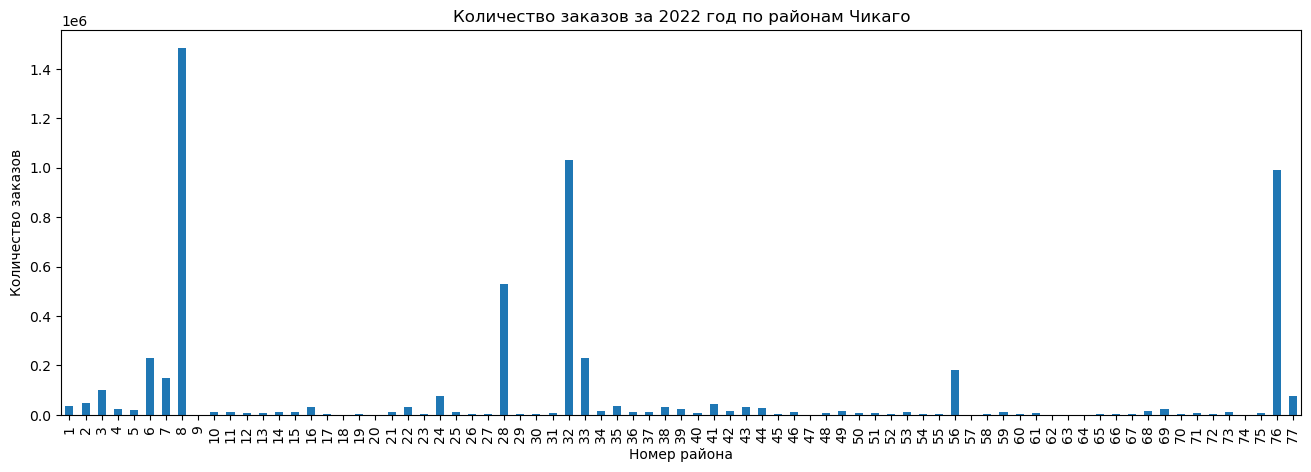

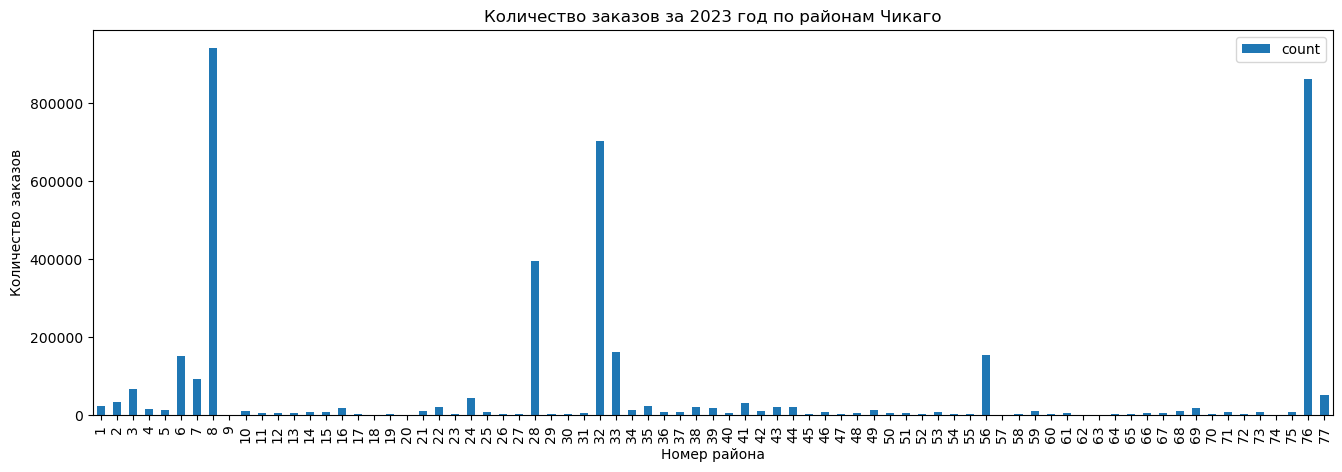

In [ ]:
(df_22.groupBy("Pickup Community Area")
      .count()
      .toPandas()
      .set_index('Pickup Community Area')
      .sort_index()
      .plot(kind='bar',
            legend=False,
            figsize=(16,5),
            title='Количество заказов за 2022 год по районам Чикаго',
            xlabel='Номер района',
            ylabel='Количество заказов'));

(df_23.groupBy("Pickup Community Area")
      .count()
      .toPandas()
      .set_index('Pickup Community Area')
      .sort_index()
      .plot(kind='bar',
            figsize=(16,5),
            title='Количество заказов за 2023 год по районам Чикаго',
         xlabel='Номер района', ylabel='Количество заказов')
);

Выделим Топ10 самых востребованных в такси районов и сохраним

In [ ]:
print('Топ10 районов по заказам за 22год')
area10_22 = (df_22.groupBy("Pickup Community Area")
                  .agg(count('Trip ID').alias('count'))
                  .sort('count', ascending=False)
)
area10_22.show(10)

print('Топ10 районов по заказам за 23год')
area10_23 = (df_23.groupBy("Pickup Community Area")
                  .agg(count('Trip ID').alias('count'))
                  .sort('count', ascending=False)
)

area10_23.show(10)
area10 = (area10_23.limit(10).fillna(0)
                   .select(col('Pickup Community Area').alias('area'))\
                   .collect()
)
top10_area = [value.area for value in area10]
top10_area

Топ10 районов по заказам за 22год
+---------------------+-------+
|Pickup Community Area|  count|
+---------------------+-------+
|                    8|1482195|
|                   32|1031002|
|                   76| 989879|
|                   28| 531270|
|                   33| 229643|
|                    6| 229347|
|                   56| 183445|
|                    7| 150635|
|                    3| 100678|
|                   77|  76036|
+---------------------+-------+
only showing top 10 rows

Топ10 районов по заказам за 23год
+---------------------+------+
|Pickup Community Area| count|
+---------------------+------+
|                    8|939996|
|                   76|862048|
|                   32|702603|
|                   28|394604|
|                   33|161161|
|                   56|153437|
|                    6|151978|
|                    7| 92285|
|                    3| 66633|
|                   77| 50840|
+---------------------+------+
only showing top 10 rows

[8, 76, 32, 28, 33, 56, 6, 7, 3, 77]

Сохраним список топ районов по заказам

In [ ]:
area10 = df_23.groupBy("Pickup Community Area")\
                  .agg(count('Trip ID').alias('count'))\
                  .sort('count', ascending=False)\
                  .limit(10)\
                  .select(col('Pickup Community Area').alias('area'))\
                  .collect()

top10_area = [value.area for value in area10]
top10_area

[8, 76, 32, 28, 33, 56, 6, 7, 3, 77]

Посмотрим в каких районах самые большие срединие чеки за такси.

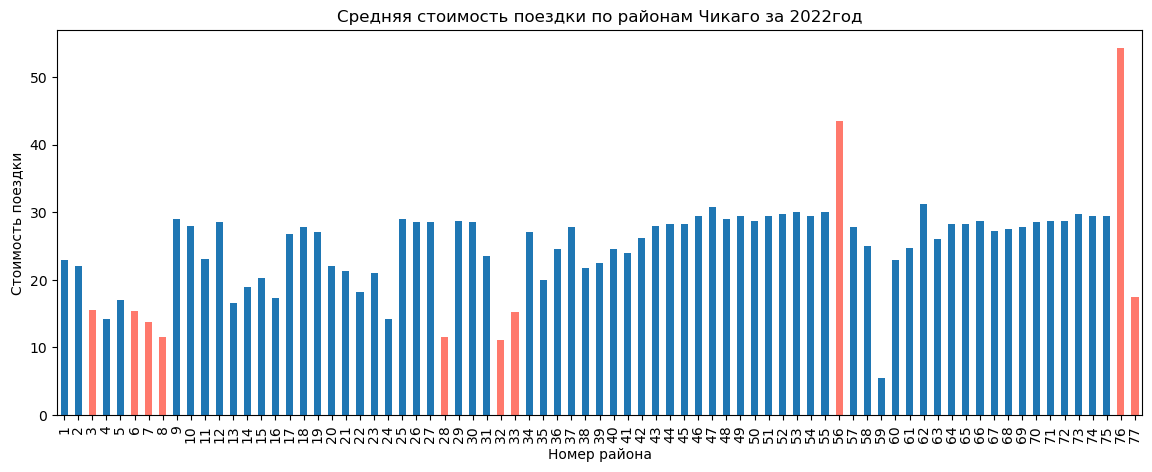

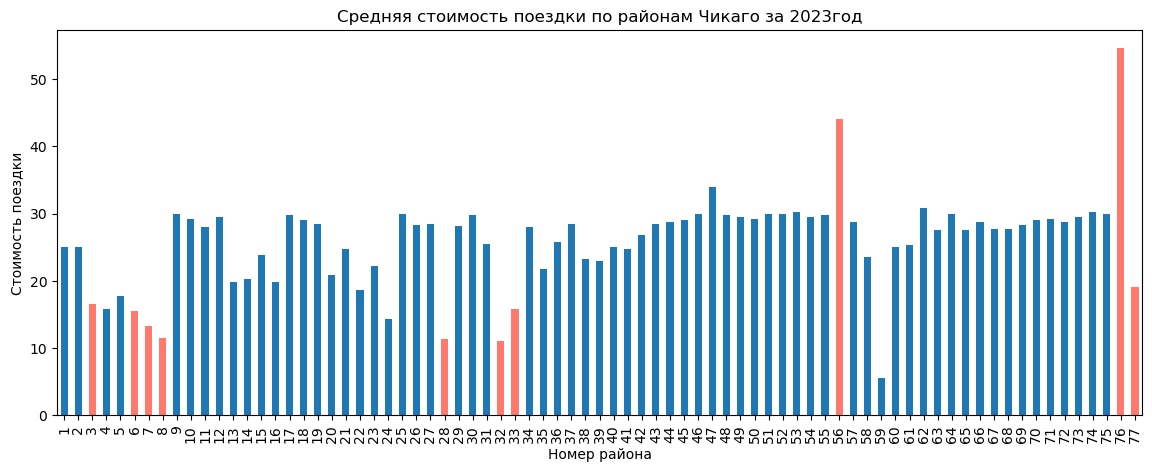

In [ ]:
pan_22 = (df_22['Trip Total', 'Pickup Community Area']
             .groupBy("Pickup Community Area")
             .agg({'Trip Total': 'median'})
             .toPandas()
             .set_index('Pickup Community Area')
             .sort_index())
ax = pan_22.plot(kind='bar',
                 legend=False,
                 figsize=(14,5),
                 title='Средняя стоимость поездки по районам Чикаго за 2022год',
                 xlabel='Номер района',
                 ylabel='Стоимость поездки')
for i in range(10):
    ax.patches[pan_22.index.get_indexer(top10_area)[i]].set_facecolor('xkcd:salmon')

pan_23 = (df_23['Trip Total', 'Pickup Community Area']
             .groupBy("Pickup Community Area")
             .agg({'Trip Total': 'median'})
             .toPandas()
             .set_index('Pickup Community Area')
             .sort_index())
ax = pan_23.plot(kind='bar',
                 legend=False,
                 figsize=(14,5),
                 title='Средняя стоимость поездки по районам Чикаго за 2023год',
                 xlabel='Номер района',
                 ylabel='Стоимость поездки')
for i in range(10):
    ax.patches[pan_23.index.get_indexer(top10_area)[i]].set_facecolor('xkcd:salmon')

Изучим среднюю длительность поездки по районам.

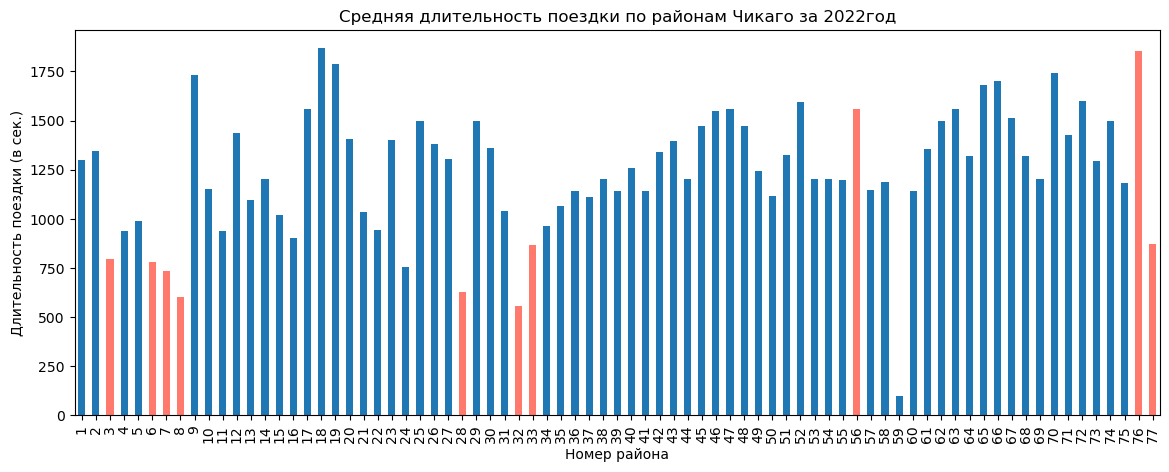

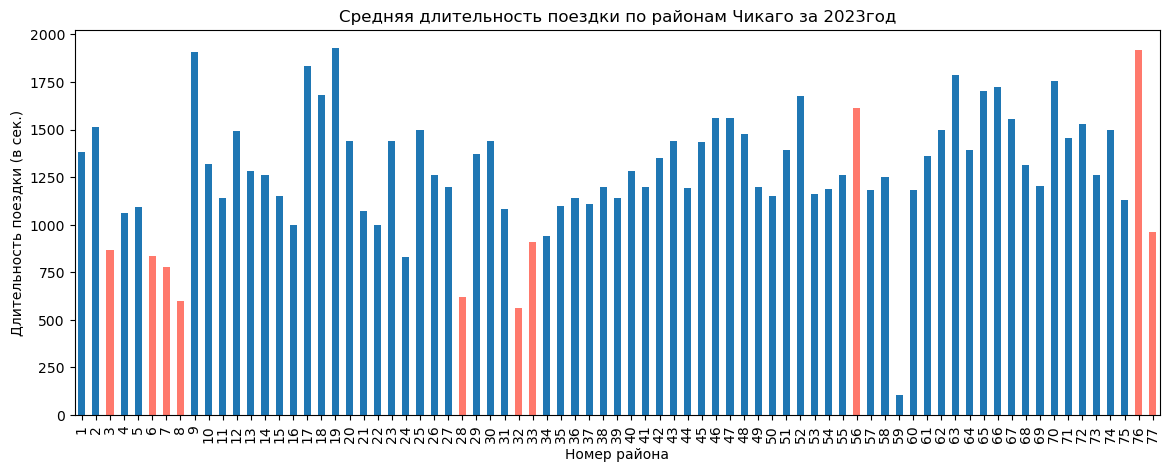

In [ ]:
pan_22 = (df_22['Trip Seconds', 'Pickup Community Area']
             .groupBy("Pickup Community Area")
             .agg({'Trip Seconds': 'median'})
             .toPandas()
             .set_index('Pickup Community Area')
             .sort_index())
ax = pan_22.plot(kind='bar',
                 legend=False,
                 figsize=(14,5),
                 title='Средняя длительность поездки по районам Чикаго за 2022год',
                 xlabel='Номер района',
                 ylabel='Длительность поездки (в сек.)')
for i in range(10):
    ax.patches[pan_22.index.get_indexer(top10_area)[i]].set_facecolor('xkcd:salmon')

pan_23 = (df_23['Trip Seconds', 'Pickup Community Area']
             .groupBy("Pickup Community Area")
             .agg({'Trip Seconds': 'median'})
             .toPandas()
             .set_index('Pickup Community Area')
             .sort_index())
ax = pan_23.plot(kind='bar',
                 legend=False,
                 figsize=(14,5),
                 title='Средняя длительность поездки по районам Чикаго за 2023год',
                 xlabel='Номер района',
                 ylabel='Длительность поездки (в сек.)')
for i in range(10):
    ax.patches[pan_23.index.get_indexer(top10_area)[i]].set_facecolor('xkcd:salmon')

Изучим среднюю дальность поездки по районам.

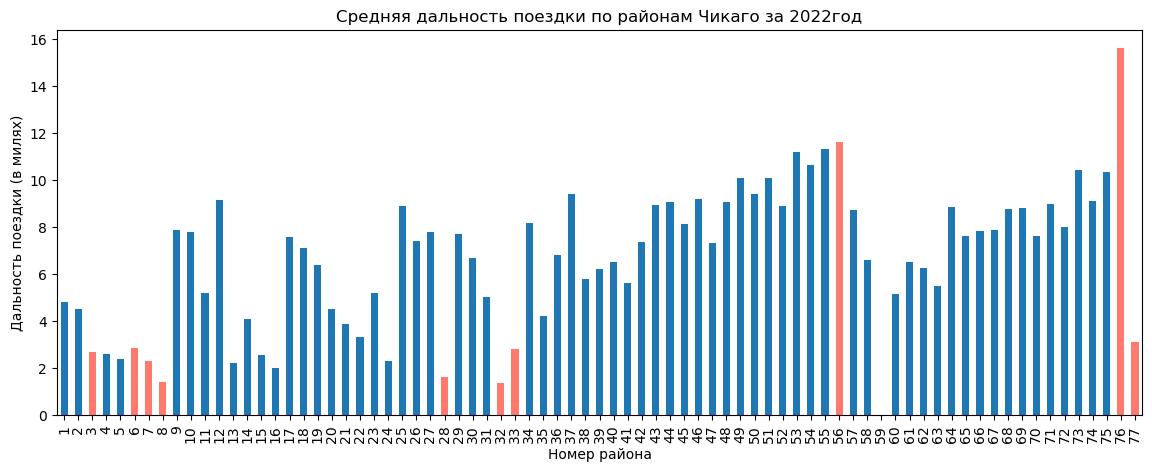

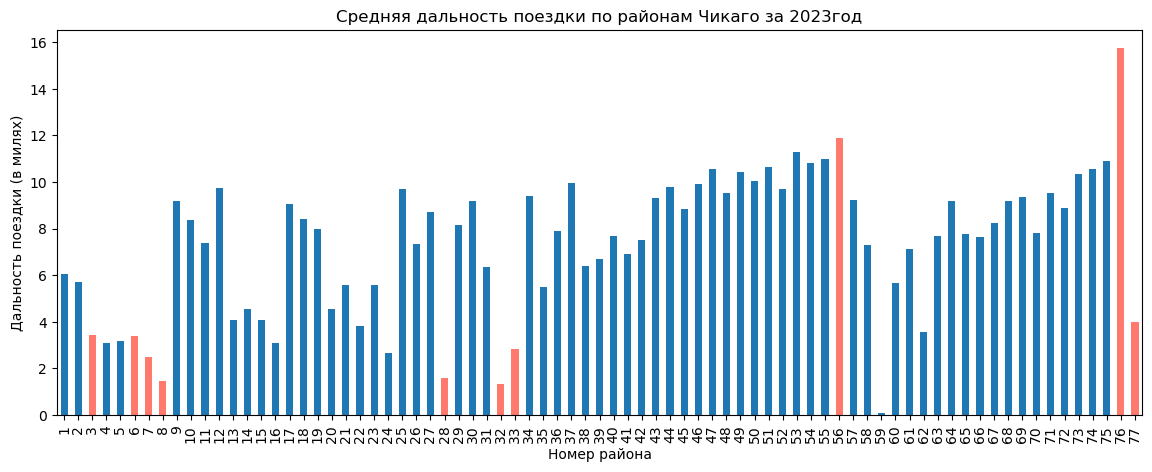

In [ ]:
pan_22 = (df_22['Trip Miles', 'Pickup Community Area']
             .groupBy("Pickup Community Area")
             .agg({'Trip Miles': 'median'})
             .toPandas()
             .set_index('Pickup Community Area')
             .sort_index())
ax = pan_22.plot(kind='bar',
                 legend=False,
                 figsize=(14,5),
                 title='Средняя дальность поездки по районам Чикаго за 2022год',
                 xlabel='Номер района',
                 ylabel='Дальность поездки (в милях)')
for i in range(10):
    ax.patches[pan_22.index.get_indexer(top10_area)[i]].set_facecolor('xkcd:salmon')

pan_23 = (df_23['Trip Miles', 'Pickup Community Area']
             .groupBy("Pickup Community Area")
             .agg({'Trip Miles': 'median'})
             .toPandas()
             .set_index('Pickup Community Area')
             .sort_index())
ax = pan_23.plot(kind='bar',
                 legend=False,
                 figsize=(14,5),
                 title='Средняя дальность поездки по районам Чикаго за 2023год',
                 xlabel='Номер района',
                 ylabel='Дальность поездки (в милях)')
for i in range(10):
    ax.patches[pan_23.index.get_indexer(top10_area)[i]].set_facecolor('xkcd:salmon')

Рассмотрим какой способ оплаты предпочитают жители Чикаго.

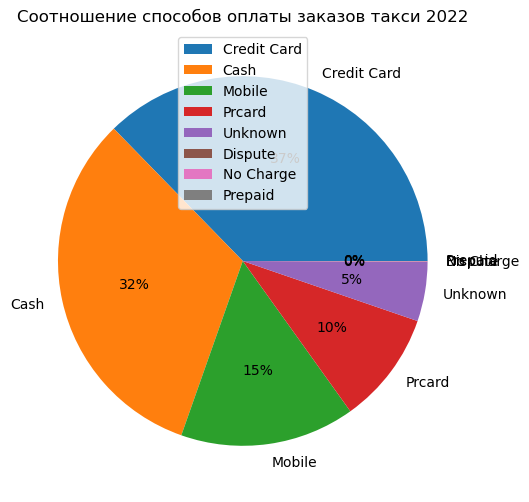

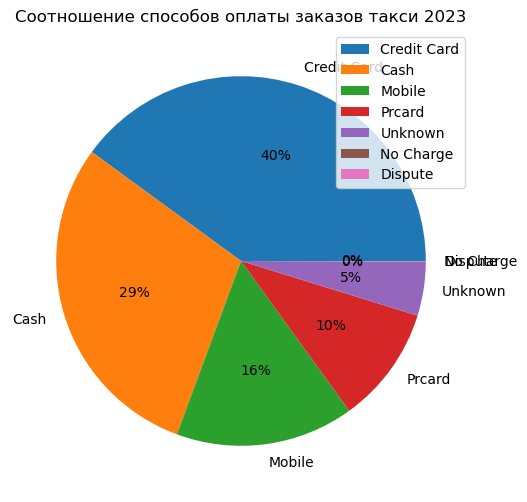

In [ ]:
df_22['Trip ID', 'Payment Type'].groupBy("Payment Type")\
                                .agg({'Trip ID': 'count'})\
                                .orderBy(col('count(Trip ID)').desc())\
                                .toPandas()\
                                .set_index('Payment Type')\
                                .plot(kind='pie',
                                      y='count(Trip ID)',
                                      ylabel='',
                                      xlabel='',
                                      autopct='%1.0f%%',
                                      title='Соотношение способов оплаты заказов такси 2022',
                                      figsize=(6,6)),\
df_23['Trip ID', 'Payment Type'].groupBy("Payment Type")\
                                .agg({'Trip ID': 'count'})\
                                .orderBy(col('count(Trip ID)').desc())\
                                .toPandas()\
                                .set_index('Payment Type')\
                                .plot(kind='pie',
                                      y='count(Trip ID)',
                                      ylabel='',
                                      xlabel='',
                                      autopct='%1.0f%%',
                                      title='Соотношение способов оплаты заказов такси 2023',
                                      figsize=(6,6));

Вывод:
1) На графике распределения количества заказов сильно выделяются 10-13 районов, в которых значительно больше заказов такси, чем в других. За 0.5 года практически не поменялась.
2) Район 76 сильно выделяется на фоне остальных большим количеством заказов, длительностью, дальностью поездох и высокой стоимость. Вероятно это крупный жилой район на окраине Чикаго.
3) У районов 8 и 32 район наоборот при большом количестве заказов стоимость и дальность поездох ниже остальных.
4) В целом картина за 2023 и 2024 год очень похожая по различным показателям.
5) Жители Чикаго предпочитаю традиционные методы оплаты банковской картой и наличными. Тем не менее процент безналичных способов оплаты расёт (кредитная карта, мобильный телефон). Это отражает 2023 год.

### Исследуем изменение количества заказов во времени.

Уберем ненужные столбцы

In [ ]:
cols_drop = ['Trip End Timestamp', 'Taxi ID', 'Fare', 'Tips', 'Tolls', 'Extras', 'Payment Type']

In [ ]:
df_22 = df_22.drop(*cols_drop)
df_23 = df_23.drop(*cols_drop)
df_22.cache(), df_23.cache()

(DataFrame[Trip ID: string, Trip Start Timestamp: string, Trip Seconds: int, Trip Miles: double, Pickup Community Area: int, Dropoff Community Area: int, Trip Total: double],
 DataFrame[Trip ID: string, Trip Start Timestamp: string, Trip Seconds: int, Trip Miles: double, Pickup Community Area: int, Dropoff Community Area: int, Trip Total: double])

Приведём время начала поездки к подходящему типу.

In [ ]:
df_22 = df_22.withColumn('DT', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a')))).cache()
df_23 = df_23.withColumn('DT', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a')))).cache()

In [ ]:
df_23.summary('count').show()

+-------+-------+--------------------+------------+----------+---------------------+----------------------+----------+
|summary|Trip ID|Trip Start Timestamp|Trip Seconds|Trip Miles|Pickup Community Area|Dropoff Community Area|Trip Total|
+-------+-------+--------------------+------------+----------+---------------------+----------------------+----------+
|  count|4153474|             4153474|     4152790|   4153463|              4153474|               4153474|   4146954|
+-------+-------+--------------------+------------+----------+---------------------+----------------------+----------+



In [ ]:
data_ts = (df_22.groupBy('DT')\
                 .pivot("Pickup Community Area")\
                 .agg({'Trip ID': 'count'})\
                 .orderBy(col('DT')))\
                 .union(df_23.groupBy('DT')\
                             .pivot("Pickup Community Area")\
                             .agg({'Trip ID': 'count'})\
                             .orderBy('DT'))\
                 .fillna(0)\
                 .toPandas()\
                 .set_index('DT')

Проанализируем изменение количества заказов для самых загруженных районов.

### Анализ района №3

#### Изменение среднего значения для разных временных признаков

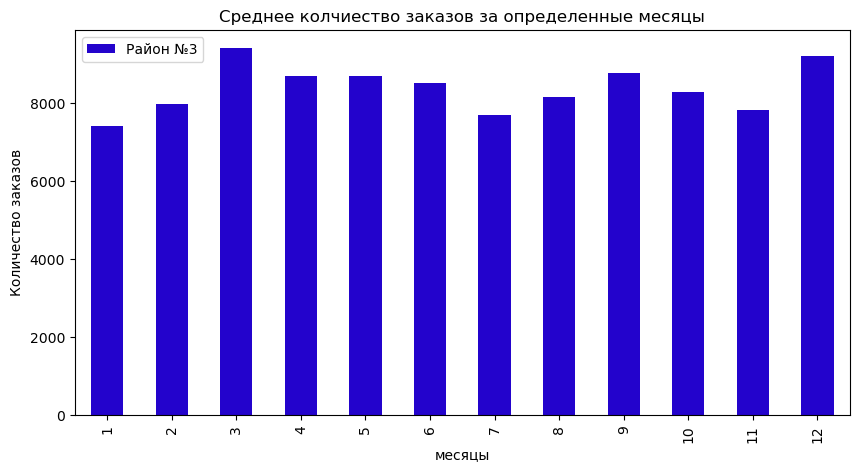

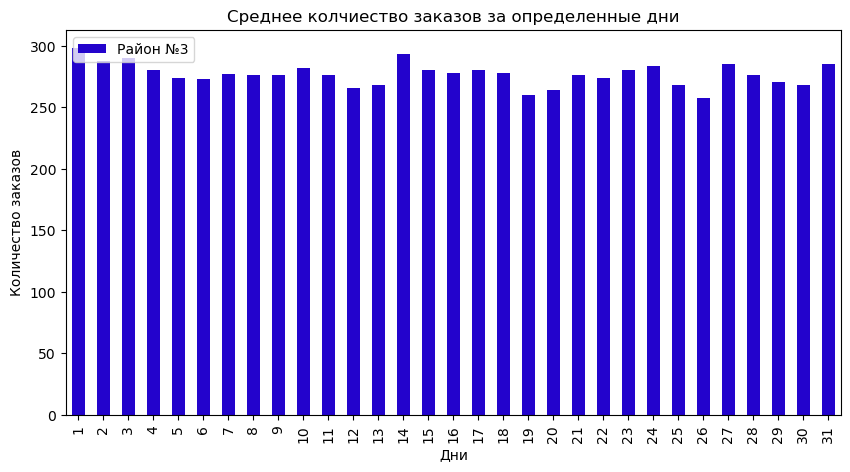

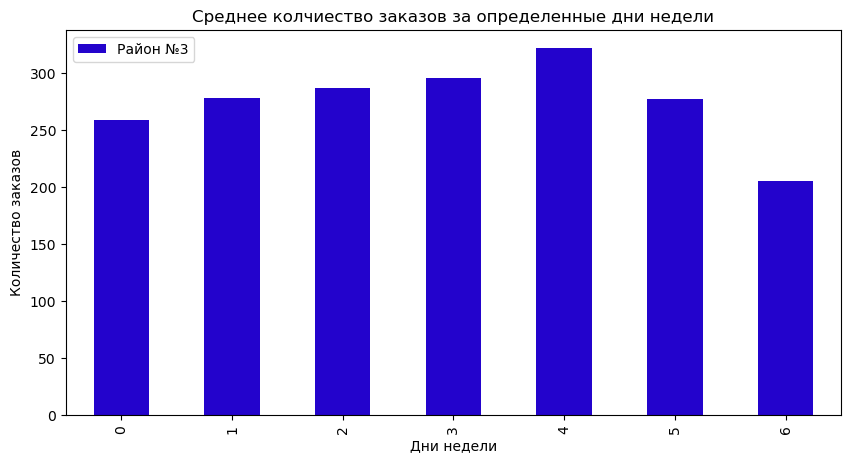

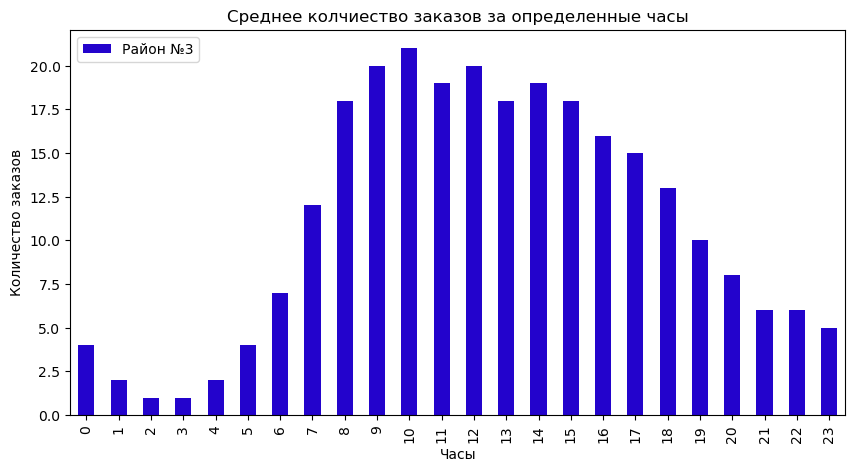

In [ ]:
area_num = '3'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

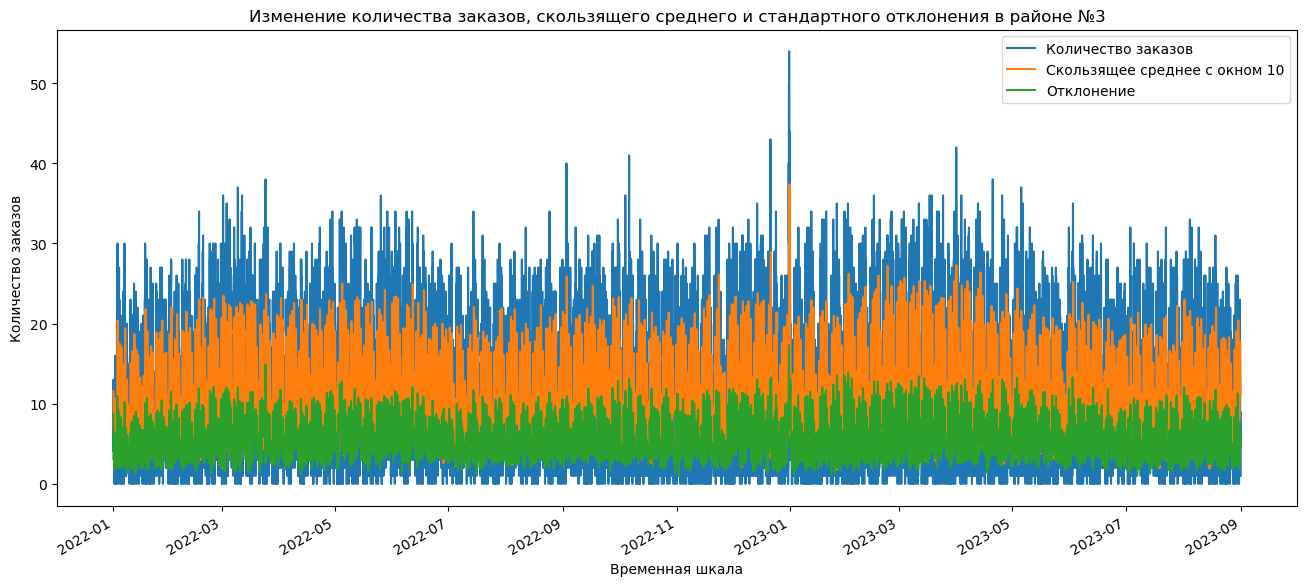

In [ ]:
stationarity_plot(data_ts, area_num)

Ряд выглядит стационарным. Продевём дополнительный тест.

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



P-значение: 0.000000
При уровне значимости 0.05: Нулевая гипотеза отвергнута – Временной ряд стационарен
При уровне значимости 0.01: Нулевая гипотеза отвергнута – Временной ряд стационарен


Вывод Р3:
1) Обнаружена сезонность по часам в течение дня. С 1 до 5 утра услушами такси практически не пользуются. Самое активное время с 8 до 18.
2) Обнаружена созонность по дням недели. В пятницу больше всего заказов, а в воскресенье меньше всего.
4) В марте и декабре заказов больше всего, а в январе и июле меньше.
5) Временной ряд стационарный.

### Анализ района №6

#### Изменение среднего значения для разных временных признаков

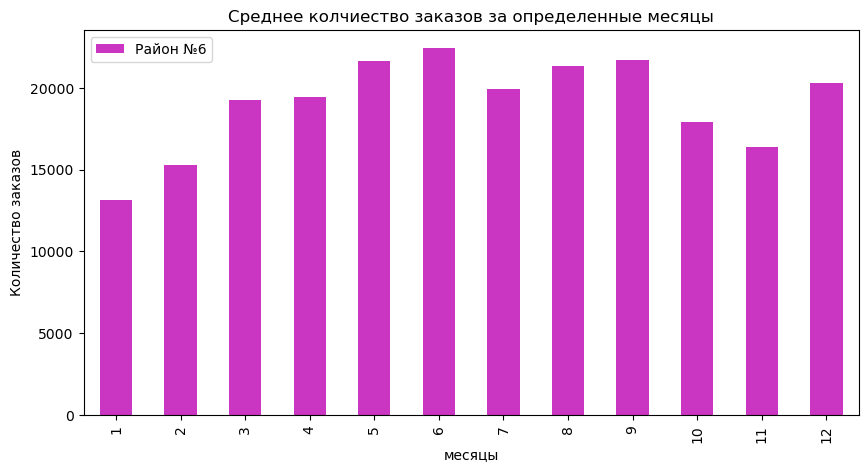

In [ ]:
area_num = '6'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
data_ts['rolling_mean'] = data_ts[area_num].shift().rolling(5).mean()
data_ts['std'] = data_ts[area_num].rolling(5).std()
data_ts[[area_num, 'rolling_mean', 'std']].dropna().plot(figsize=(16,7));
plt.title('Изменение количества заказов, скользящего среднего и стандартного отклонения')
plt.ylabel('Количество заказов')
plt.xlabel('Временная шкала')
plt.show()
data_ts.drop(columns=['rolling_mean', 'std'], inplace=True)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р6:
1) Обнаружена сезонность по часам в течение дня. С 0 до 6 утра услушами такси практически не пользуются. Самое активное время с 7 до 19.
2) Обнаружена созонность по дням недели. В пятницу и субботу больше всего заказов.
4) В январе и феврале меньше всего заказов.
5) Временной ряд стационарный.

### Анализ района №7

#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '7'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р7:
1) Обнаружена сезонность по часам в течение дня. С 0 до 6 утра услушами такси практически не пользуются. Самое активное время с 17 до 19.
2) Обнаружена созонность по дням недели. В пятницу и субботу больше всего заказов.
4) В январе меньше всего заказов.
5) Временной ряд стационарный.

### Анализ района №8

#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '8'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р8:
1) Обнаружена сезонность по часам в течение дня. С 0 до 7 утра услушами такси практически не пользуются. Самое активное время с 16 до 19.
2) Обнаружена созонность по дням недели. В воскресенье меньше всего заказов.
4) В январе и феврале меньше всего заказов.
5) Временной ряд стационарный.

### Анализ района №28

#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '28'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р28:
1) Обнаружена сезонность по часам в течение дня. С 0 до 7 утра услушами такси практически не пользуются. Самое активное время с 8 до 10.
2) Обнаружена созонность по дням недели. В субботу и воскресенье больше всего заказов.
4) В январе и феврале меньше всего заказов.
5) Временной ряд стационарный.

### Анализ района №32

#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '32'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р32:
1) Обнаружена сезонность по часам в течение дня. С 23 до 7 утра услушами такси практически не пользуются. Самое активное время с 16 до 19.
2) Обнаружена созонность по дням недели. В субботу и воскресенье менше всего заказов.
4) В январе и феврале меньше всего заказов.
5) Временной ряд стационарный.

### Анализ района №33

#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '33'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р33:
1) Обнаружена сезонность по часам в течение дня. С 22 до 7 утра услушами такси практически не пользуются. Самое активное время с 13 до 19.
2) Обнаружена созонность по дням недели. В воскресенье меньше всего заказов.
4) С декабря по февраль и в августе меньше всего заказов.
5) Временной ряд стационарный.

### Анализ района №56

#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '56'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р56:
1) Обнаружена сезонность по часам в течение дня. С 3 до 7 утра услушами такси практически не пользуются. Самое активное время с 12 до 0.
2) Обнаружена созонность по дням недели. В субботу меньше всего заказов.
4) С декабря по февраль меньше всего заказов.
5) Временной ряд стационарный.

### Анализ района №76


#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '76'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р76:
1) Обнаружена сезонность по часам в течение дня. С 2 до 8 утра услушами такси практически не пользуются. Самое активное время с 19 до 21.
2) Обнаружена созонность по дням недели. В субботу меньше всего заказов.
3) С декабря по февраль меньше всего заказов.
4) Временной ряд стационарный.

### Анализ района №77


#### Изменение среднего значения для разных временных признаков

In [ ]:
area_num = '77'
color = list(np.random.choice(range(1,257), size=3)/256)
time_bars(data_ts, area_num, color)

#### Анализ ряда на стационарность

In [ ]:
stationarity_plot(data_ts, area_num)

#### Тест Дики - Фуллера на стационарность

In [ ]:
result = adfuller(data_ts[area_num])

print('P-значение: %f' % result[1])

alpha_1 = 0.05
alpha_2 = 0.01
a1 = 'При уровне значимости ' + str(alpha_1)
a2 = 'При уровне значимости ' + str(alpha_2)

if (result[1] < alpha_1):
    print (f'{a1}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a1}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

if (result[1] < alpha_2):
    print (f'{a2}: Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print (f'{a2}: Нулевая гипотеза не отвергнута – Временной ряд не стационарен')



Вывод Р77:
1) Обнаружена сезонность по часам в течение дня. С 0 до 6 утра услушами такси практически не пользуются. Самое активное время с 8 до 16.
2) Обнаружена созонность по дням недели. В воскресенье меньше всего заказов.
3) Временной ряд стационарный.

<b>Изучив 10 самых востребованных в такси районов можно сказать, что каждый из них имеет суточную сезонность и достаточно сильно отличаются. Для каждого района стоит выбирать отдельную модель машинного обучения. <br>Тем не менее у каждого района количество заказов довольно стабильное с течением времени, что подтверждают результаты теста Дики Фкллера.</b>

## Обучение и тестирование моделей машинного обучения.

Для оценки моделей машинного обучения будем использовать метрики MAE и MDAPE (аналог MAPE). Основной будет - MAE.

Перезагрузим спарк, чтобы освободить память после анализа данных и загрузим данные по новой.

In [ ]:
spark.stop()

In [ ]:

SPARK_MASTER_IP = '172.19.0.2'
spark = (SparkSession.builder.appName("pyspark-taxi-forecasting")
                     .master(f"spark://{SPARK_MASTER_IP}:7077")
                     .config("spark.executor.cores", 1)
                     .config("spark.task.cpus", 1)
                   # .config("spark.jars.packages", "ai.catboost:catboost-spark_3.4_2.12:2.12")
                     .getOrCreate())

In [ ]:
schema = StructType([
    StructField("Trip ID", StringType(), nullable=True),
    StructField("Taxi ID", StringType(), nullable=True),
    StructField("Trip Start Timestamp", StringType(), nullable=True),
    StructField("Trip End Timestamp", StringType(), nullable=True),
    StructField("Trip Seconds", IntegerType(), nullable=True),
    StructField("Trip Miles", FloatType(), nullable=True),
    StructField("Pickup Census Tract", StringType(), nullable=True),
    StructField("Dropoff Census Tract", StringType(), nullable=True),
    StructField("Pickup Community Area", ShortType(), nullable=True),
    StructField("Dropoff Community Area", ShortType(), nullable=True),
    StructField("Fare", FloatType(), nullable=True),
    StructField("Tips", FloatType(), nullable=True),
    StructField("Tolls", FloatType(), nullable=True),
    StructField("Extras", FloatType(), nullable=True),
    StructField("Trip Total", FloatType(), nullable=True),
    StructField("Payment Type", StringType(), nullable=True),
    StructField("Company", StringType(), nullable=True),
    StructField("Pickup Centroid Latitude", DoubleType(), nullable=True),
    StructField("Pickup Centroid Longitude", DoubleType(), nullable=True),
    StructField("Pickup Centroid Location", StringType(), nullable=True),
    StructField("Dropoff Centroid Latitude", DoubleType(), nullable=True),
    StructField("Dropoff Centroid Longitude", DoubleType(), nullable=True),
    StructField("Dropoff Centroid  Location", StringType(), nullable=True)]
)

Выберем последние 100 дней и на них будем обучать тестовые модели по всему Чикаго.

In [ ]:
start_time = time.time()

df_ts = (spark.read.load('data/Taxi_Trips_-_2023.csv', format='csv', header='true', inferSchema='true', schema=schema)
              .withColumn('Trip Start Timestamp', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))))
              .withColumn('Trip End Timestamp', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))))
              .fillna(value=0, subset=['Pickup Community Area', 'Dropoff Community Area'])\
              .groupby('Trip Start Timestamp')
              .agg(count('Trip ID').alias('orders'))
              .orderBy(desc('Trip Start Timestamp')).limit(2400).orderBy(col('Trip Start Timestamp'))
              .fillna(value=0)
              .withColumn('month', month('Trip Start Timestamp'))
              .withColumn('day', dayofmonth('Trip Start Timestamp'))
              .withColumn('dayofweek', dayofweek('Trip Start Timestamp'))
              .withColumn('hour', hour('Trip Start Timestamp'))
        )

df_ts.cache()
df_ts.show(5)
print(f'\n=== Время выполнения: {int(time.time() - start_time)} seconds ===')

+--------------------+------+-----+---+---------+----+
|Trip Start Timestamp|orders|month|day|dayofweek|hour|
+--------------------+------+-----+---+---------+----+
| 2023-05-24 01:00:00|   151|    5| 24|        4|   1|
| 2023-05-24 02:00:00|    73|    5| 24|        4|   2|
| 2023-05-24 03:00:00|    77|    5| 24|        4|   3|
| 2023-05-24 04:00:00|   130|    5| 24|        4|   4|
| 2023-05-24 05:00:00|   260|    5| 24|        4|   5|
+--------------------+------+-----+---+---------+----+
only showing top 5 rows


=== Время выполнения: 0 seconds ===


### Обучение моделей на базовых временных признаках для Чикаго

#### Модель линейной регрессии с выделенными временными признаками для всего Чикаго.

Выделим 80% под тренировочную выборку и 20 под валидационную.

In [ ]:
data_train, data_test = ts_split(df_ts, .8)

Подготовим Pipeline для линейной регрессии.

In [ ]:
lr = LinearRegression(featuresCol='features',
                      labelCol='orders',
                      predictionCol='pred_orders',
            )
pipeline_lr_cat = make_pipe(lr)

Обучим линейную модель предсказания количества всех заказов в Чикаго и оценим качество модели.

In [ ]:
start_time = time.time()

model_lr = pipeline_lr_cat.fit(data_train)
predictions = model_lr.transform(data_test)
print(f'Для линейной модели (Чикаго) метрики (MAE, MDAPE):\n{mae_mdape(predictions)}')
print(f'\n=== Время выполнения: {int(time.time() - start_time)} seconds ===')

Для линейной модели (Чикаго) метрики (MAE, MDAPE):
(120.47, 0.165)

=== Время выполнения: 3 seconds ===


#### Модель градиентного бустинга GBT Regressor

In [ ]:
start_time = time.time()

gbtr = GBTRegressor(featuresCol='features',
                           labelCol='orders',
                           predictionCol='pred_orders')
pipeline_gbtr_cat = make_pipe(gbtr)
model_gbtr = pipeline_gbtr_cat.fit(data_train)
predictions = model_gbtr.transform(data_test)
print(f'Для модели градиентного бустинга (Чикаго) метрики (MAE, MDAPE):\n{mae_mdape(predictions)}')

print(f'\n=== Время выполнения: {int(time.time() - start_time)} seconds ===')

Для модели градиентного бустинга (Чикаго) метрики (MAE, MDAPE):
(98.96, 0.132)

=== Время выполнения: 12 seconds ===


С базовыми признаками модель градиентного бустинга показывает себя лучше по обеим метрикам.

### Обучение моделей с лагами и скользящим средним для Чикаго

#### Модель линейной регрессии.

Добавим лаги и скользящее среднее.

In [ ]:
df_ts_lag, num_columns = lag_avg(df_ts)

Выделим 80% под тренировочную выборку и 20 под валидационную.

In [ ]:
data_train, data_test = ts_split(df_ts_lag, .8)

In [ ]:
start_time = time.time()

pipeline_lag_lr = make_pipe(lr, num_cols=num_columns)
model_lr = pipeline_lag_lr.fit(data_train)
predictions = (model_lr.transform(data_test))
print(f'Для линейной модели c лагами и скользящим средним (Чикаго) метрики (MAE, MDAPE):\n{mae_mdape(predictions)}')

print(f'\n=== Время выполнения: {int(time.time() - start_time)} seconds ===')

Для линейной модели c лагами и скользящим средним (Чикаго) метрики (MAE, MDAPE):
(56.48, 0.072)

=== Время выполнения: 2 seconds ===


#### Модель GBT Regression

In [ ]:
start_time = time.time()

pipeline_lag_gbtr = make_pipe(gbtr, num_cols=num_columns)
model_gbtr = pipeline_lag_gbtr.fit(data_train)
predictions = (model_gbtr.transform(data_test))
print(f'Для модели градиентного бустинга с лагами и скользящим средним (Чикаго) метрики (MAE, MDAPE):\n{mae_mdape(predictions)}')

print(f'\n=== Время выполнения: {int(time.time() - start_time)} seconds ===')

Для модели градиентного бустинга с лагами и скользящим средним (Чикаго) метрики (MAE, MDAPE):
(58.55, 0.079)

=== Время выполнения: 11 seconds ===


Модель линейной регрессии показала себя лучше с фиксированным количеством лагов и окном скользящего среднего.

#### Подбор количества лагов и окно скользящего среднего

Улучшим показатели моделей за счёт подбора оптимального количества лагов и окна скользящего среднего.

In [ ]:
start_time = time.time()
for i_ in [ 5, 7, 9, 11]:
    for j_ in [3, 5, 7, 9]:
        df_ts_lag, num_columns = lag_avg(df_ts, lags=i_, roll=j_)
        data_train, data_test = ts_split(df_ts_lag, .8)

        pipeline_lag_lr = make_pipe(lr, num_cols=num_columns)
        pipeline_lag_gbtr = make_pipe(gbtr, num_cols=num_columns)
        print('Lags -', i_, ' Roll -', j_)

        model_lr = pipeline_lag_lr.fit(data_train)
        predictions = (model_lr.transform(data_test))
        print(f'Линейная регрессия (MAE, MDAPE): {mae_mdape(predictions)}')

        model_gbtr = pipeline_lag_gbtr.fit(data_train)
        predictions = model_gbtr.transform(data_test)
        print(f'GBTR (MAE, MDAPE): {mae_mdape(predictions)}\n')

print("--- Время выполнения: %s seconds ---" % int(time.time() - start_time))

Lags - 5  Roll - 3
Линейная регрессия (MAE, MDAPE): (56.37, 0.074)
GBTR (MAE, MDAPE): (58.47, 0.081)

Lags - 5  Roll - 5
Линейная регрессия (MAE, MDAPE): (56.38, 0.074)
GBTR (MAE, MDAPE): (58.56, 0.079)

Lags - 5  Roll - 7
Линейная регрессия (MAE, MDAPE): (56.56, 0.076)
GBTR (MAE, MDAPE): (58.75, 0.074)

Lags - 5  Roll - 9
Линейная регрессия (MAE, MDAPE): (56.63, 0.073)
GBTR (MAE, MDAPE): (55.71, 0.078)

Lags - 7  Roll - 3
Линейная регрессия (MAE, MDAPE): (56.54, 0.075)
GBTR (MAE, MDAPE): (58.05, 0.079)

Lags - 7  Roll - 5
Линейная регрессия (MAE, MDAPE): (56.54, 0.076)
GBTR (MAE, MDAPE): (58.89, 0.083)

Lags - 7  Roll - 7
Линейная регрессия (MAE, MDAPE): (56.53, 0.076)
GBTR (MAE, MDAPE): (59.93, 0.081)

Lags - 7  Roll - 9
Линейная регрессия (MAE, MDAPE): (56.51, 0.074)
GBTR (MAE, MDAPE): (57.38, 0.083)

Lags - 9  Roll - 3
Линейная регрессия (MAE, MDAPE): (56.45, 0.072)
GBTR (MAE, MDAPE): (55.51, 0.07)

Lags - 9  Roll - 5
Линейная регрессия (MAE, MDAPE): (56.46, 0.073)
GBTR (MAE, MDAPE

Самый лучший результат показала модель GBTR при 9 лагах и окне скользящего среднего - 3 (GBTR: 55.51, 0.07).<br>
Модель линейной регрессии при таких значениях показала себя лучше, чем при первоначальных значениях лагов и окна среднего.

#### Замена столбца 'hour' на синусоидку и косинусоиду с периодом 24 часа.

Данное преобравание возможно благодаря тому, что каждые сутки динамика изменения количества заказов повторяется.

In [ ]:
start_time = time.time()

df_ts_lag, num_columns = lag_avg(df_ts, lags=9, roll=3)
df_ts_lag = df_ts_lag.withColumn('hour_cos', 2*np.pi*col('hour')/24)\
                     .withColumn('hour_sin', sin(col('hour_cos')))\
                     .withColumn('hour_cos', cos(col('hour_cos')))
data_train, data_test = ts_split(df_ts_lag, .8)
num_columns.extend(['hour_sin', 'hour_cos'])

pipeline_lag_lr = make_pipe(lr,
                            cat_cols=['month', 'day', 'dayofweek'],
                            num_cols=num_columns)
pipeline_lag_gbtr = make_pipe(gbtr,
                              cat_cols=['month', 'day', 'dayofweek'],
                              num_cols=num_columns)

model_lr = pipeline_lag_lr.fit(data_train)
predictions = (model_lr.transform(data_test))
print(f'Линейная регрессия (MAE, MDAPE): {mae_mdape(predictions)}')

model_gbtr = pipeline_lag_gbtr.fit(data_train)
predictions = model_gbtr.transform(data_test)
print(f'GBTR (MAE, MDAPE): {mae_mdape(predictions)}\n')

print("=== Время выполнения: %s seconds ===" % int(time.time() - start_time))

Линейная регрессия (MAE, MDAPE): (63.81, 0.081)
GBTR (MAE, MDAPE): (53.58, 0.072)

=== Время выполнения: 13 seconds ===


При данном преобразовании (GBTR) качество лучшей модели улучшилось, но метрики для линейной модели ухудшились. <br>Данное преобразование будем использовать только для градиентного бустинга.

#### Подбор гиперпараметров для модели градиентного бустинга

In [ ]:
best_mae=10000
best_mdape = 1
iterator=0
for maxIter in [5,50,150]:
    for maxDepth in [3,5,7]:
        for stepSize in [0.01,0.1]:
            start_time = time.time()
            iterator+=1
            df_ts_lag, num_columns = lag_avg(df_ts, lags=9, roll=3)
            df_ts_lag = df_ts_lag.withColumn('hour_cos', 2*np.pi*col('hour')/24)\
                                 .withColumn('hour_sin', sin(col('hour_cos')))\
                                 .withColumn('hour_cos', cos(col('hour_cos')))
            cat_cols=['month', 'day', 'dayofweek']

            data_train, data_test = ts_split(df_ts_lag, .8)
            num_columns.extend(['hour_sin', 'hour_cos'])

            gbtr = GBTRegressor(featuresCol='features',
                                labelCol='orders',
                                predictionCol='pred_orders',
                                maxIter=maxIter,
                                maxDepth=maxDepth,
                                stepSize=stepSize)
            pipeline_lag_gbtr = make_pipe(gbtr, cat_cols=cat_cols, num_cols=num_columns)
            model_gbtr = pipeline_lag_gbtr.fit(data_train)
            predictions = (model_gbtr.transform(data_test))
            result = mae_mdape(predictions)
            print(f'Step {iterator}: MAE - {result[0]}, MDAPE - {result[1]}')
            if result[0] < best_mae:
                best_mae = result[0]
                best_mdape = result[1]
                bestm_txt = 'MAE - '+str(best_mae)+', MDAPE - '+str(best_mdape)
                message = 'Max Depth: '+str(maxDepth)+', Max Iter: '+str(maxIter)+', Step Size: '+str(stepSize)
            print("=== Время обучения: %s seconds ===" % int(time.time() - start_time))
print(f'Лучшая модель по Чикаго: {bestm_txt} ({message})')


Step 1: MAE - 92.87, MDAPE - 0.126
=== Время обучения: 3 seconds ===
Step 2: MAE - 83.63, MDAPE - 0.116
=== Время обучения: 3 seconds ===
Step 3: MAE - 60.94, MDAPE - 0.083
=== Время обучения: 4 seconds ===
Step 4: MAE - 58.93, MDAPE - 0.082
=== Время обучения: 4 seconds ===
Step 5: MAE - 55.88, MDAPE - 0.073
=== Время обучения: 5 seconds ===
Step 6: MAE - 52.99, MDAPE - 0.07
=== Время обучения: 5 seconds ===
Step 7: MAE - 83.5, MDAPE - 0.115
=== Время обучения: 17 seconds ===
Step 8: MAE - 53.6, MDAPE - 0.073
=== Время обучения: 17 seconds ===
Step 9: MAE - 58.14, MDAPE - 0.079
=== Время обучения: 27 seconds ===
Step 10: MAE - 50.91, MDAPE - 0.071
=== Время обучения: 26 seconds ===
Step 11: MAE - 52.59, MDAPE - 0.068
=== Время обучения: 41 seconds ===
Step 12: MAE - 49.91, MDAPE - 0.071
=== Время обучения: 40 seconds ===
Step 13: MAE - 71.44, MDAPE - 0.094
=== Время обучения: 52 seconds ===
Step 14: MAE - 47.49, MDAPE - 0.062
=== Время обучения: 52 seconds ===
Step 15: MAE - 54.81, MD

Лучшая модель по Чикаго: MAE - 47.49, MDAPE - 0.062 (Max Depth: 3, Max Iter: 150, Step Size: 0.1). <br>Подбор гиперпараметров позволил улучшить качество предсказаний.

### Обучение моделей предсказаний по районам

In [ ]:
start_time = time.time()
# Загрузка и оБъединение фреймов, ресемпл по часу, группировка по времени и районам, сортировка, заполнение нулями
df_ts_area_full = (spark.read.load('data/Taxi_Trips_-_2022.csv', format='csv', header='true', inferSchema='true', schema=schema)
                   .union(spark.read.load('data/Taxi_Trips_-_2023.csv', format='csv', header='true', inferSchema='true', schema=schema))
                   .withColumn('Trip Start Timestamp', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))))
                   .withColumn('Trip End Timestamp', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))))
                   .fillna(value=0, subset=['Pickup Community Area', 'Dropoff Community Area'])
                   .groupby('Trip Start Timestamp')
                   .pivot('Pickup Community Area')
                   .agg(count('Trip ID'))
                   .orderBy(desc('Trip Start Timestamp')).limit(2400)
                   .orderBy(col('Trip Start Timestamp'))
                   .fillna(value=0)
                   .withColumn('month', month('Trip Start Timestamp'))
                   .withColumn('day', dayofmonth('Trip Start Timestamp'))
                   .withColumn('dayofweek', dayofweek('Trip Start Timestamp'))
                   .withColumn('hour', hour('Trip Start Timestamp'))
                   .withColumn('hour_cos', 2*np.pi*col('hour')/24)
                   .withColumn('hour_sin', sin(col('hour_cos')))
                   .withColumn('hour_cos', cos(col('hour_cos')))
)

df_ts_area_full.cache()
print("=== Время выполнения: %s seconds ===" % int(time.time() - start_time))

=== Время выполнения: 27 seconds ===


### Протестируем модели на 3 самых загруженных районах.

In [ ]:
if not 'top10_area' in globals():
    top10_area = [8, 76, 32, 28, 33, 56, 6, 7, 3, 77]

In [ ]:
#перебор районов
gbtr = GBTRegressor(featuresCol='features',
                        labelCol='orders',
                        predictionCol='pred_orders',
                        maxIter=150,
                        maxDepth=3,
                        stepSize=0.1)

for area in top10_area[:3]:
    start_time = time.time()
    cols = ["Trip Start Timestamp", str(area), 'month', 'day', 'dayofweek', 'hour', 'hour_sin', 'hour_cos']
    df_ts_area = df_ts_area_full.select(cols).withColumn('orders', col(str(area)))
    df_ts_area, num_columns = lag_avg(df_ts_area, lags=9, roll=3)
    data_train, data_valid, data_test = ts_split(df_ts_area, .8, val=True)

    print(f'Для района №{area}:')
    pipeline_lag_lr = make_pipe(lr, num_cols=num_columns)
    model_lr = pipeline_lag_lr.fit(data_train)
    predictions = (model_lr.transform(data_valid))
    print(f'LR (MAE, MDAPE): {mae_mdape(predictions)}')

    num_columns.extend(['hour_sin', 'hour_cos'])
    pipeline_lag_gbtr = make_pipe(gbtr,
                              cat_cols=['month', 'day', 'dayofweek'],
                              num_cols=num_columns)
    model_gbtr = pipeline_lag_gbtr.fit(data_train)
    predictions = (model_gbtr.transform(data_valid))
    print(f'GBTR MAE, MDAPE): {mae_mdape(predictions)}')
    print(f"--- Время обучения: {int(time.time() - start_time)} seconds ---" )



Для района №8:
LR (MAE, MDAPE): (18.3, 0.105)
GBTR MAE, MDAPE): (15.85, 0.096)
--- Время обучения: 59 seconds ---
Для района №76:
LR (MAE, MDAPE): (21.72, 0.142)
GBTR MAE, MDAPE): (20.22, 0.13)
--- Время обучения: 60 seconds ---
Для района №32:
LR (MAE, MDAPE): (17.33, 0.157)
GBTR MAE, MDAPE): (15.22, 0.142)
--- Время обучения: 62 seconds ---


### Создание моделей для всех районов

Для обучения моделей используем данные за весь имеющийся период.

In [ ]:
start_time = time.time()

df_ts_area_full = (spark.read.load('data/Taxi_Trips_-_2022.csv', format='csv', header='true', inferSchema='true', schema=schema)
                   .union(spark.read.load('data/Taxi_Trips_-_2023.csv', format='csv', header='true', inferSchema='true', schema=schema))
                   .withColumn('Trip Start Timestamp', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))))
                   .withColumn('Trip End Timestamp', (f.date_trunc('hour', to_timestamp(col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))))
                   .fillna(value=0, subset=['Pickup Community Area', 'Dropoff Community Area'])
                   .groupby('Trip Start Timestamp')
                   .pivot('Pickup Community Area')
                   .agg(count('Trip ID'))
                   .orderBy(col('Trip Start Timestamp'))
                   .fillna(value=0)
                   .withColumn('month', month('Trip Start Timestamp'))
                   .withColumn('day', dayofmonth('Trip Start Timestamp'))
                   .withColumn('dayofweek', dayofweek('Trip Start Timestamp'))
                   .withColumn('hour', hour('Trip Start Timestamp'))
                   .withColumn('hour_cos', 2*np.pi*col('hour')/24)
                   .withColumn('hour_sin', sin(col('hour_cos')))
                   .withColumn('hour_cos', cos(col('hour_cos')))
)

df_ts_area_full.cache()
print("=== Время выполнения: %s seconds ===" % int(time.time() - start_time))

=== Время выполнения: 9 seconds ===


In [ ]:
gbtr = GBTRegressor(featuresCol='features',
                        labelCol='orders',
                        predictionCol='pred_orders',
                        maxIter=150,
                        maxDepth=3,
                        stepSize=0.1)

for area in range(1,78):
    start_time = time.time()
    cols = ["Trip Start Timestamp", str(area), 'month', 'day', 'dayofweek', 'hour', 'hour_sin', 'hour_cos']
    df_ts_area = df_ts_area_full.select(cols).withColumn('orders', col(str(area)))
    df_ts_area, num_columns = lag_avg(df_ts_area, lags=9, roll=3)
    data_train, data_valid, data_test = ts_split(df_ts_area, .8, val=True)

    print(f'Для района №{area}:')
    pipeline_lag_lr = make_pipe(lr, num_cols=num_columns)
    model_lr = pipeline_lag_lr.fit(data_train)
    predictions = (model_lr.transform(data_valid)
                           .withColumn('pred_orders', round('pred_orders')))
    result_lr = mae_mdape(predictions)

    num_columns.extend(['hour_sin', 'hour_cos'])
    pipeline_lag_gbtr = make_pipe(gbtr,
                              cat_cols=['month', 'day', 'dayofweek'],
                              num_cols=num_columns)
    model_gbtr = pipeline_lag_gbtr.fit(data_train)
    predictions = (model_gbtr.transform(data_valid)
                             .withColumn('pred_orders', round('pred_orders')))
    result_gbtr = mae_mdape(predictions)
    globals()['data_test_'+str(area)] = data_test
    if result_lr[0] < result_gbtr[0]:
        print(f'* LR (MAE, MDAPE): {result_lr[0], result_lr[1]}')
        print(f'GBTR (MAE, MDAPE): {result_gbtr[0], result_gbtr[1]}')
        globals()['model_'+str(area)] = model_lr
    else:
        print(f'LR (MAE, MDAPE): {result_lr[0], result_lr[1]}')
        print(f'* GBTR (MAE, MDAPE): {result_gbtr[0], result_gbtr[1]}')
        globals()['model_'+str(area)] = model_gbtr

    print(f"--- Время обучения: {int(time.time() - start_time)} seconds ---" )


Для района №1:
LR (MAE, MDAPE): (1.56, 0.333)
* GBTR (MAE, MDAPE): (1.52, 0.333)
--- Время обучения: 75 seconds ---
Для района №2:
LR (MAE, MDAPE): (1.89, 0.333)
* GBTR (MAE, MDAPE): (1.81, 0.25)
--- Время обучения: 75 seconds ---
Для района №3:
LR (MAE, MDAPE): (2.99, 0.259)
* GBTR (MAE, MDAPE): (2.86, 0.25)
--- Время обучения: 75 seconds ---
Для района №4:
LR (MAE, MDAPE): (1.37, 0.375)
* GBTR (MAE, MDAPE): (1.34, 0.333)
--- Время обучения: 74 seconds ---
Для района №5:
LR (MAE, MDAPE): (1.17, 0.5)
* GBTR (MAE, MDAPE): (1.14, 0.429)
--- Время обучения: 74 seconds ---
Для района №6:
LR (MAE, MDAPE): (7.4, 0.242)
* GBTR (MAE, MDAPE): (6.48, 0.2)
--- Время обучения: 74 seconds ---
Для района №7:
LR (MAE, MDAPE): (4.77, 0.276)
* GBTR (MAE, MDAPE): (4.23, 0.242)
--- Время обучения: 75 seconds ---
Для района №8:
LR (MAE, MDAPE): (19.63, 0.112)
* GBTR (MAE, MDAPE): (17.39, 0.099)
--- Время обучения: 74 seconds ---
Для района №9:
LR (MAE, MDAPE): (0.17, 1.0)
* GBTR (MAE, MDAPE): (0.17, 1.0)


Кау видим для большого количества районов погрешность предсказаний довольно высокая, несмотря на то, что абсолютная ошибка низкая. В первую очередь это связано с тем, что количество заказов такси в данных районах очень низкое, что не позволяет модели качественно отрабатывать.

### Проверка лучших моделей

Спрогнозируем количество заказов на последний час, а также сравним с константной моделью, которая будет использовать среднее значение для прогноза.

In [ ]:
good_area = []
bad_area = []
for area in range(1,78):
    start_time = time.time()
    predict_c = const_model (df_ts_area_full, area)
    result_const = mae_mdape(predict_c)
    model_best = globals()['model_'+str(area)]
    predict_best = model_best.transform(globals()['data_test_'+str(area)])
    result_best = mae_mdape(predict_best)
    print(f'Для района №{area}:')
    if result_const[0] < result_best[0]:
        bad_area.append(area)
        print(f'* CONST (MAE, MDAPE): {result_const[0], result_const[1]}')
        print(f'MODEL (MAE, MDAPE): {result_best[0], result_best[1]}')
    else:
        good_area.append(area)
        print(f'CONST (MAE, MDAPE): {result_const[0], result_const[1]}')
        print(f'* MODEL (MAE, MDAPE): {result_best[0], result_best[1]}')
    print(f"--- Время проверки: {int(time.time() - start_time)} seconds ---" )

Для района №1:
CONST (MAE, MDAPE): (3.0, 3.0)
* MODEL (MAE, MDAPE): (0.46, 0.457)
--- Время проверки: 6 seconds ---
Для района №2:
CONST (MAE, MDAPE): (5.0, 5.0)
* MODEL (MAE, MDAPE): (0.61, 0.613)
--- Время проверки: 6 seconds ---
Для района №3:
CONST (MAE, MDAPE): (7.0, 1.4)
* MODEL (MAE, MDAPE): (0.12, 0.024)
--- Время проверки: 6 seconds ---
Для района №4:
CONST (MAE, MDAPE): (2.0, 2.0)
* MODEL (MAE, MDAPE): (0.07, 0.068)
--- Время проверки: 6 seconds ---
Для района №5:
* CONST (MAE, MDAPE): (0.0, 0.0)
MODEL (MAE, MDAPE): (0.76, 0.379)
--- Время проверки: 7 seconds ---
Для района №6:
CONST (MAE, MDAPE): (14.0, 1.167)
* MODEL (MAE, MDAPE): (0.1, 0.008)
--- Время проверки: 6 seconds ---
Для района №7:
CONST (MAE, MDAPE): (2.0, 0.133)
* MODEL (MAE, MDAPE): (0.06, 0.004)
--- Время проверки: 6 seconds ---
Для района №8:
CONST (MAE, MDAPE): (90.0, 1.233)
* MODEL (MAE, MDAPE): (1.32, 0.018)
--- Время проверки: 6 seconds ---
Для района №9:
* CONST (MAE, MDAPE): (0.0, None)
MODEL (MAE, MDAP

Для некоторых районов константная модель сработала даже лучше, но опираться на данный результат не рекомендуется, так как для проверки был выбран лишь один час.
Высокая погрешность выбранной модели в некоторых районах связана с малым количеством заказов, либо аномалиями как для 56 района.

# Вывод

Возпользовавшись предоставленными данными о поездках на такси был проведён анализ анализ спроса на такси в 22-23 году в Чикаго.<br> Изучив общую информацию по всему городу, был проведён более подробный анализ самых популярных районов для заказа такси. По каждому из них была выявлена динамика по месяцам, годам и в течение дня. Для каждого из районов была свойственна сезонность, а именно в течение дня каждом из ТОП10 районов был в определённые часы явно выраженный высокий спрос и также в определенный интервал низкий. Также используя тест Дики-Фуллера выяснили, что временные ряды для каждого из ТОП10 районов стационарны, что говорит о стагнации с в течение 22-23 года.
Для создания моделей предсказания были выделеные целевые временные признаки (день, месяц, день недели и час). Для обучения применялась модель Линейной регрессии и модель градиентного бустинга (GBT Regressor).
Обучение проходило в несколько этапов:
1) Модель обучалась на базовых признаках и предсказывала количество заказов по часу пл всему городу Чикаго.. Выбран интервал последних 100 дней (самые актуальные данные).
2) Были созданы новые признаки, включающие в себе данные о количестве заказов такси в предыдущие периоды и среднем количестве заказов за последние несколько часов.
3) Для модели градиентного бустинга были подобраны оптимальные гиперпараметры и добавлены 2 новых признака, которые отражали периодичность спроса изо дня в день.
4) Модели с оптимальными гиперпараметрами были обучены по каждому району по отдельности, выбрана самая лучшая и протестированы. В качестве теста был предсказан спрос на последний час и результаты модели сравнили с константной моделью.<br>

Для оценки качества моделей использовались метрики MAE и MDAPE (аналог MAPE, но с использованием медианного значения). Основной метрикой использовалась MAE.
По одному предсказанию некорректно было сравнивать выбранные модели с константными, тем не менее данная процедура была проведена и результаты её отражены.


    